In [1]:
import utils as sw_utils
import os
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as plt_dates
from hmmlearn.hmm import GaussianHMM
import numpy as np
import seaborn as sns
import itertools
import pandas as pd
%matplotlib inline

data_root = os.path.join(os.environ['HOME'], 'vl/StopWatch/scripts/downloads')

### Loading Data
We're loading data. This data was a day in the office, somewhat arbitrarily chosen because it looks like I was being pretty still.

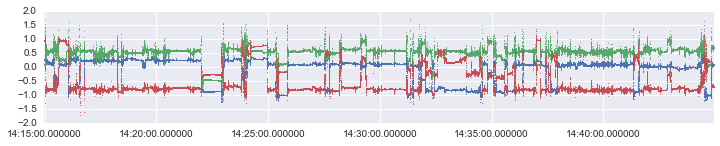

In [2]:
filename = 'p1602-s1234-20170830T215223169Z.bin'
data = sw_utils._load_data(join(data_root, filename))

start_idx = next(
    idx
    for idx in xrange(len(data.date))
    if data.start_date <= data.date[idx]
)

minute = 60*50
st = 15*minute + start_idx
end = st+30*minute

X = np.stack([data.x[st:end], data.y[st:end], data.z[st:end]]).T

dates = np.array([sw_utils._parse_date(d) for d in data.date[st:end]])

def _plot_ts():
    plt.figure(figsize=(12, 2))
    for idx in range(X.shape[-1]):
        _=plt.plot_date(dates, X[:, idx], '.',  markersize=2)
    _=plt.ylim([-2, 2])
_plot_ts()

In [ ]:
# Make an HMM instance and execute fit
model6 = GaussianHMM(
    n_components=6, n_iter=1000
).fit(X)

# We'll also fit a model with fewer components
model4 = GaussianHMM(
    n_components=4, n_iter=1000
).fit(X)

### HMM

We fit 2 HMM models above. We'll compare them in the below figures. The topmost figure is the data again. The next 2 figures take a look at the time spent in each specific HMM state for each of the models we've fit. The plots below show the relevant data for a given state. It's really interesting to see that some states seem to capture stable periods in the data and other states seem to be modeling transitions or more transitory states. Increasing the number of HMM states doesn't dramatically change some of the more stable periods, but seems to carve out things from the more transitory states.

/Users/carlos/vl/rnd/env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/carlos/vl/rnd/env/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


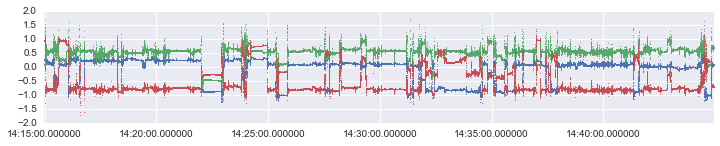

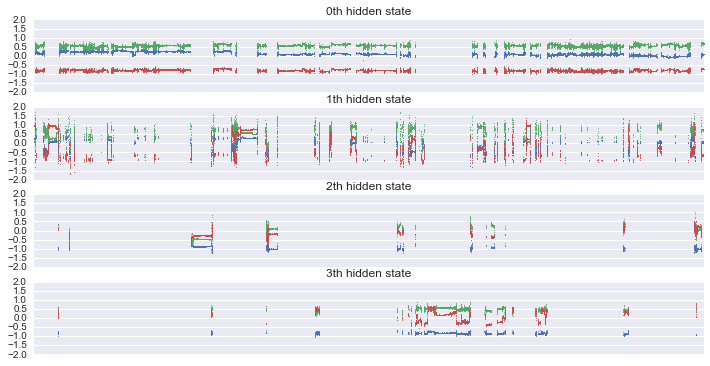

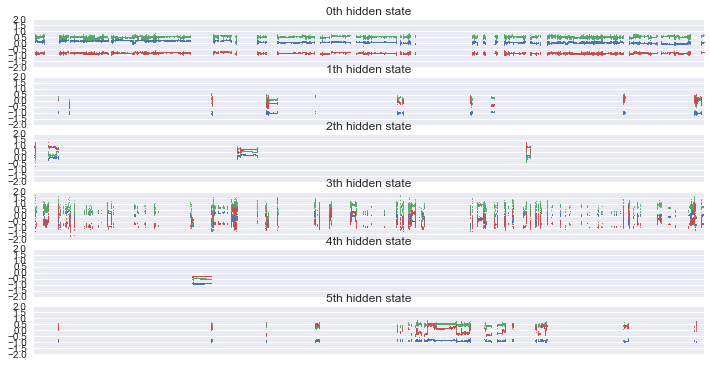

In [5]:
_plot_ts()

for model in [model4, model6]:
    # Predict hidden states for the dataset.
    hidden_states = model.predict(X)

    fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12, 6))
    for i, ax in enumerate(axs):
        # Use fancy indexing to plot data in each state.
        mask = hidden_states == i
        ax.plot_date(dates[mask], X[mask, :], ".", markersize=2)
        ax.set_title("{0}th hidden state".format(i))

        # Format the ticks.
        ax.xaxis.set_major_locator(plt_dates.YearLocator())
        ax.xaxis.set_minor_locator(plt_dates.MonthLocator())

        ax.grid(True)
        _=plt.ylim([-2, 2])

### Heatmaps & HMM states

Here are our acceleration heatmaps, now with projections to every pair of dimensions. We also overlay the states detected by the HMM as red dots. These coincide with darker patches on the heatmap, which might be intuitive given the success in above plots in detecting stable places. It seems like the more transitory states sort of end up out in the middle of nowhere It might be good to plot the variance associated with the state, as we'd expect these states holding transitions to have higher variance?

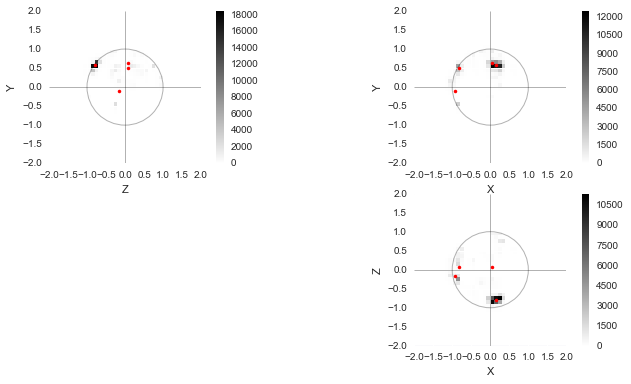

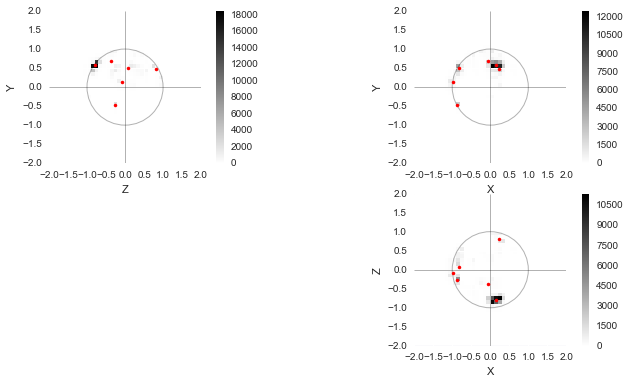

In [6]:
def _draw_accel_heatmap(x, y, labels):
    xlim = ylim = [-2, 2]
    cm = plt.cm.gray_r
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=40, range=[xlim, ylim])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    grid_kw = dict(
        color=[0, 0, 0, 0.3],
        linewidth=1,
    )
    plt.vlines(0, *ylim, **grid_kw)
    plt.hlines(0, *xlim, **grid_kw)
    gravity = plt.Circle((0, 0), 1, fill=False, **grid_kw)
    plt.gca().add_artist(gravity)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm, interpolation='none')
    plt.colorbar()

def _draw_accel_heatmaps(X, model):
    config = [
        (1, (2, 1), ('Z', 'Y')),
        (2, (0, 1), ('X', 'Y')),
        (4, (0, 2), ('X', 'Z')),
    ]
    for plot_idx, idxs, labels in config:
        plt.subplot(2, 2, plot_idx)
        _draw_accel_heatmap(X[:, idxs[0]], X[:, idxs[1]], labels)
        _=plt.plot(model.means_[:, idxs[0]], model.means_[:, idxs[1]], 'r.')

plt.figure(figsize=(12, 6))
plt.title('Data with HMM states=4 in red')
_draw_accel_heatmaps(X, model4)

plt.figure(figsize=(12, 6))
plt.title('Data with HMM states=6 in red')
_draw_accel_heatmaps(X, model6)


### hyperparameters

I decided to try looking at different hyperparameters of the HMM. We'd need to read more to make a decision about the covariance types. We should also look to try this data on more data at once, on possibly larger subsets of a participant's data. We should also consider only modeling focus sessions as that would maybe help constrain the amount of individual variability. In general, more components seems to help fit, and full covariance seems better. We'd have to evaluate this in a cross-validated way and make sure to be fitting on more heterogeneous data as well, as this particular sample data set is a bit simplistic and short.

In [ ]:
record = {}
covariance_types = ['diag', 'full']
number_components = [3, 4, 5, 6, 8, 10, 14]

for n_comp in number_components:
    for cov in covariance_types:
        # Make an HMM instance and execute fit
        model = GaussianHMM(n_components=n_comp, covariance_type=cov, n_iter=1000).fit(X)

        # Predict the optimal sequence of internal hidden state
        hidden_states = model.predict(X)

        # score the inputs. TODO make this CV
        p = model.score(X)

        record[n_comp, cov] = p

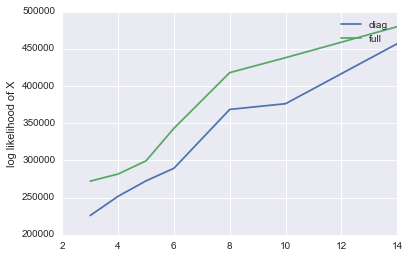

In [8]:
plt.figure()
for cov in covariance_types:
    some_rec = sorted([
        (n_comp, value)
        for (n_comp,c), value in record.iteritems() if c==cov])
    plt.plot(*zip(*some_rec), label=cov)
plt.legend()
_=plt.ylabel('log likelihood of X')